# Explore R mem problem in GWAS_QC

### Memory usage profile

In [2]:
install.packages("profvis")
install.packages("dplyr")
install.packages("igraph")

also installing the dependencies ‘yaml’, ‘stringi’, ‘htmlwidgets’, ‘stringr’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘purrr’, ‘generics’, ‘R6’, ‘tidyselect’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘lattice’, ‘Matrix’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [1]:
library(profvis)
profvis({
  library(dplyr)
  library(igraph)
  # Remove related individuals while keeping maximum number of individuals
  # this function is simplified from: 
  # https://rdrr.io/cran/plinkQC/src/R/utils.R
  #' @param relatedness [data.frame] containing pair-wise relatedness estimates
  #' (in column [relatednessRelatedness]) for individual 1 (in column
  #' [relatednessIID1] and individual 2 (in column [relatednessIID1]). Columns
  #' relatednessIID1, relatednessIID2 and relatednessRelatedness have to present,
  #' while additional columns such as family IDs can be present. Default column
  #' names correspond to column names in output of plink --genome
  #' (\url{https://www.cog-genomics.org/plink/1.9/ibd}). All original
  #' columns for pair-wise highIBDTh fails will be returned in fail_IBD.
  #' @param relatednessTh [double] Threshold for filtering related individuals.
  #' Individuals, whose pair-wise relatedness estimates are greater than this
  #' threshold are considered related.
  relatednessFilter <- function(relatedness, 
                                relatednessTh,
                                relatednessIID1="IID1", 
                                relatednessIID2="IID2",
                                relatednessRelatedness="KINSHIP") {
    # format data
    if (!(relatednessIID1 %in% names(relatedness))) {
      stop(paste("Column", relatednessIID1, "for relatedness not found!"))
    }
    if (!(relatednessIID2 %in% names(relatedness))) {
      stop(paste("Column", relatednessIID1, "for relatedness not found!"))
    }
    if (!(relatednessRelatedness %in% names(relatedness))) {
      stop(paste("Column", relatednessRelatedness,
                 "for relatedness not found!"))
    }
    
    iid1_index <- which(colnames(relatedness) == relatednessIID1)
    iid2_index <- which(colnames(relatedness) == relatednessIID2)
    
    relatedness[,iid1_index] <- as.character(relatedness[,iid1_index])
    relatedness[,iid2_index] <- as.character(relatedness[,iid2_index])
    
    relatedness_names <- names(relatedness)
    names(relatedness)[iid1_index] <- "IID1"
    names(relatedness)[iid2_index] <- "IID2"
    names(relatedness)[names(relatedness) == relatednessRelatedness] <- "M"
    
    # Remove symmetric IID rows
    relatedness_original <- relatedness
    relatedness <- dplyr::select_(relatedness, ~IID1, ~IID2, ~M)
    
    sortedIDs <- data.frame(t(apply(relatedness, 1, function(pair) {
      c(sort(c(pair[1], pair[2])))
    })), stringsAsFactors=FALSE)
    keepIndex <- which(!duplicated(sortedIDs))
    
    relatedness_original <- relatedness_original[keepIndex,]
    relatedness <- relatedness[keepIndex,]
    
    # individuals with at least one pair-wise comparison > relatednessTh
    # return NULL to failIDs if no one fails the relatedness check
    highRelated <- dplyr::filter_(relatedness, ~M > relatednessTh)
    if (nrow(highRelated) == 0) {
      return(list(relatednessFails=NULL, failIDs=NULL))
    }
    
    # all samples with related individuals
    allRelated <- c(highRelated$IID1, highRelated$IID2)
    uniqueIIDs <- unique(allRelated)
    
    # Further selection of samples with relatives in cohort
    multipleRelative <- unique(allRelated[duplicated(allRelated)])
    singleRelative <- uniqueIIDs[!uniqueIIDs %in% multipleRelative]
    
    highRelatedMultiple <- highRelated[highRelated$IID1 %in% multipleRelative |
                                         highRelated$IID2 %in% multipleRelative,]
    highRelatedSingle <- highRelated[highRelated$IID1 %in% singleRelative &
                                       highRelated$IID2 %in% singleRelative,]
    
    # Only one related samples per individual
    if(length(singleRelative) != 0) {
      # randomly choose one to exclude
      failIDs_single <- highRelatedSingle[,1]
      
    } else {
      failIDs_single <- NULL
    }
    
    # An individual has multiple relatives
    if(length(multipleRelative) != 0) {
      relatedPerID <- lapply(multipleRelative, function(x) {
        tmp <- highRelatedMultiple[rowSums(
          cbind(highRelatedMultiple$IID1 %in% x,
                highRelatedMultiple$IID2 %in% x)) != 0,1:2]
        rel <- unique(unlist(tmp))
        return(rel)
      })
      names(relatedPerID) <- multipleRelative
      
      keepIDs_multiple <- lapply(relatedPerID, function(x) {
        pairwise <- t(combn(x, 2))
        index <- (highRelatedMultiple$IID1 %in% pairwise[,1] &
                    highRelatedMultiple$IID2 %in% pairwise[,2]) |
          (highRelatedMultiple$IID1 %in% pairwise[,2] &
             highRelatedMultiple$IID2 %in% pairwise[,1])
        combination <- highRelatedMultiple[index,]
        combination_graph <- igraph::graph_from_data_frame(combination,
                                                           directed=FALSE)
        all_iv_set <- igraph::ivs(combination_graph)
        length_iv_set <- sapply(all_iv_set, function(x) length(x))
        
        if (all(length_iv_set == 1)) {
          # check how often they occurr elsewhere
          occurrence <- sapply(x, function(id) {
            sum(sapply(relatedPerID, function(idlist) id %in% idlist))
          })
          # if occurrence the same everywhere, pick the first, else keep
          # the one with minimum occurrence elsewhere
          if (length(unique(occurrence)) == 1) {
            nonRelated <- sort(x)[1]
          } else {
            nonRelated <- names(occurrence)[which.min(occurrence)]
          }
        } else {
          nonRelated <- all_iv_set[which.max(length_iv_set)]
        }
        return(nonRelated)
      })
      keepIDs_multiple <- unique(unlist(keepIDs_multiple))
      failIDs_multiple <- c(multipleRelative[!multipleRelative %in%
                                               keepIDs_multiple])
    } else {
      failIDs_multiple <- NULL
    }
    allFailIIDs <- c(failIDs_single, failIDs_multiple)
    relatednessFails <- lapply(allFailIIDs, function(id) {
      fail_inorder <- relatedness_original$IID1 == id &
        relatedness_original$M > relatednessTh
      fail_inreverse <- relatedness_original$IID2 == id &
        relatedness_original$M > relatednessTh
      if (any(fail_inreverse)) {
        inreverse <- relatedness_original[fail_inreverse, ]
        id1 <- iid1_index
        id2 <- iid2_index
        inreverse[,c(id1, id2)] <- inreverse[,c(id2, id1)]
        names(inreverse) <- relatedness_names
      } else {
        inreverse <- NULL
      }
      inorder <- relatedness_original[fail_inorder, ]
      names(inorder) <- relatedness_names
      return(rbind(inorder, inreverse))
    })
    relatednessFails <- do.call(rbind, relatednessFails)
    if (nrow(relatednessFails) == 0) {
      relatednessFails <- NULL
      failIDs <- NULL
    } else {
      names(relatednessFails) <- relatedness_names
      rownames(relatednessFails) <- 1:nrow(relatednessFails)
      uniqueFails <- relatednessFails[!duplicated(relatednessFails[,iid1_index]),]
      failIDs <- uniqueFails[,iid1_index]
    }
    return(list(relatednessFails=relatednessFails, failIDs=failIDs))
  }
  
  
  # main code
  kin0 <- read.table('~/bioworkflows/GWAS/data/MWE_fabiha/output/rename_chr22.output.kin0', header=F, stringsAsFactor=F)
  colnames(kin0) <- c("FID1","ID1","FID2","ID2","NSNP","HETHET","IBS0","KINSHIP")
  if (TRUE) {
    rel <- relatednessFilter(kin0, 0.05, "ID1", "ID2", "KINSHIP")$failIDs
    tmp1 <- kin0[,1:2]
    tmp2 <- kin0[,3:4]
    colnames(tmp1) = colnames(tmp2) = c("FID", "ID")
    # Get the family ID for these rels so there are two columns FID and IID in the output
    lookup <- dplyr::distinct(rbind(tmp1,tmp2))
    dat <- lookup[which(lookup[,2] %in% rel),]
  } else {s
    rel <- kin0 %>% filter(KINSHIP >= 0.05)
    IID <- sort(unique(unlist(rel[, c("ID1", "ID2")])))
    dat <- data.frame(IID)
    dat <- dat %>%
      mutate(FID = IID) %>%
      select(FID, IID)
  }
  cat("There are", nrow(dat),"related individuals using a kinship threshold of 0.05\n")
  write.table(dat,'~/bioworkflows/GWAS/data/MWE_fabiha/output/rename_chr22.output.related_id', quote=FALSE, row.names=FALSE, col.names=FALSE)
})


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Warning message:
“`select_()` was deprecated in dplyr 0.7.0.
Please use `select()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message:
“`filter_()` was deprecated in dplyr 0.7.0.
Please use `filter()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


There are 47 related individuals using a kinship threshold of 0.05


HTML widgets cannot be represented in plain text (need html)

As we can observe from the result, the function igraph:ivs takes up the most memory usage. The whloe program takes 60.3Mb while function "igraph:ivs" takes 30.2Mb. Actually, to find the maximal unrelated sample set, here it uses the graph theory which can cost huge of amount time given the data scale. 

### Graph theory

From paper "A New Algorithm for Generating All the Maximal Independent Sets" they cite in package "igraph", the complexity of the calculation is O(n+m), where n is the number of samples and m is the number of relations between people.

### Other methods

From paper [Quality control, imputation and analysis of genome-wide genotyping data from the Illumina HumanCoreExome microarray](https://academic.oup.com/bfg/article/15/4/298/2412127#113395955), they just remove IBD > 0.1875.
Code: https://github.com/JoniColeman/gwas_scripts#pairwise-identical-by-descent-ibd-check

### Detailed code

In [5]:
kin0 <- read.table('~/bioworkflows/GWAS/data/MWE_fabiha/output/rename_chr22.output.kin0', header=F, stringsAsFactor=F)
colnames(kin0) <- c("FID1","ID1","FID2","ID2","NSNP","HETHET","IBS0","KINSHIP")

relatedness=kin0
relatednessTh=0.05
relatednessIID1="ID1"
relatednessIID2="ID2"
relatednessRelatedness="KINSHIP"

  # format data
  
  iid1_index <- which(colnames(relatedness) == relatednessIID1)
  iid2_index <- which(colnames(relatedness) == relatednessIID2)
  
  relatedness[,iid1_index] <- as.character(relatedness[,iid1_index])
  relatedness[,iid2_index] <- as.character(relatedness[,iid2_index])
  
  relatedness_names <- names(relatedness)
  names(relatedness)[iid1_index] <- "IID1"
  names(relatedness)[iid2_index] <- "IID2"
  names(relatedness)[names(relatedness) == relatednessRelatedness] <- "M"
  
  # Remove symmetric IID rows
  relatedness_original <- relatedness
  relatedness <- dplyr::select_(relatedness, ~IID1, ~IID2, ~M)
  
  sortedIDs <- data.frame(t(apply(relatedness, 1, function(pair) {
    c(sort(c(pair[1], pair[2])))
  })), stringsAsFactors=FALSE)
  keepIndex <- which(!duplicated(sortedIDs))
  
  relatedness_original <- relatedness_original[keepIndex,]
  relatedness <- relatedness[keepIndex,]
  
  # individuals with at least one pair-wise comparison > relatednessTh
  # return NULL to failIDs if no one fails the relatedness check
  highRelated <- dplyr::filter_(relatedness, ~M > relatednessTh)
  if (nrow(highRelated) == 0) {
    return(list(relatednessFails=NULL, failIDs=NULL))
  }
  
  # all samples with related individuals
  allRelated <- c(highRelated$IID1, highRelated$IID2)
  uniqueIIDs <- unique(allRelated)
  
  # Further selection of samples with relatives in cohort
  multipleRelative <- unique(allRelated[duplicated(allRelated)])
  singleRelative <- uniqueIIDs[!uniqueIIDs %in% multipleRelative]
  
  highRelatedMultiple <- highRelated[highRelated$IID1 %in% multipleRelative |
                                       highRelated$IID2 %in% multipleRelative,]
  highRelatedSingle <- highRelated[highRelated$IID1 %in% singleRelative &
                                     highRelated$IID2 %in% singleRelative,]
  
  # Only one related samples per individual
  if(length(singleRelative) != 0) {
    # randomly choose one to exclude
    failIDs_single <- highRelatedSingle[,1]
    
  } else {
    failIDs_single <- NULL
  }

In [22]:
cat(c("       ","\t","\t","Length","\n"))
#cat(c("kin0","\t",nrow(kin0),"\n"))
cat(c("relatedness","\t","\t",nrow(relatedness),"\n"))
cat(c("highRelated","\t","\t",nrow(highRelated),"\n"))
cat(c("highRelatedMultiple","\t",nrow(highRelatedMultiple),"\n"))
cat(c("highRelatedSingle","\t",nrow(highRelatedSingle),"\n"))
cat(c("uniqueIIDs","\t","\t",length(uniqueIIDs),"\n"))

        	 	 Length 
relatedness 	 	 1225 
highRelated 	 	 716 
highRelatedMultiple 	 716 
highRelatedSingle 	 0 
uniqueIIDs 	 	 48 


### Memory usage ~ Sample size

In [36]:
set.seed(123)
n = nrow(kin0)
n1 = sample(1:n,n*0.2)
n2 = sample(1:n,n*0.4)
n3 = sample(1:n,n*0.6)
n4 = sample(1:n,n*0.8)
n5 = sample(1:n,n)

In [41]:
cost<-function(n){
profvis({
  library(dplyr)
  library(igraph)
  # Remove related individuals while keeping maximum number of individuals
  # this function is simplified from: 
  # https://rdrr.io/cran/plinkQC/src/R/utils.R
  #' @param relatedness [data.frame] containing pair-wise relatedness estimates
  #' (in column [relatednessRelatedness]) for individual 1 (in column
  #' [relatednessIID1] and individual 2 (in column [relatednessIID1]). Columns
  #' relatednessIID1, relatednessIID2 and relatednessRelatedness have to present,
  #' while additional columns such as family IDs can be present. Default column
  #' names correspond to column names in output of plink --genome
  #' (\url{https://www.cog-genomics.org/plink/1.9/ibd}). All original
  #' columns for pair-wise highIBDTh fails will be returned in fail_IBD.
  #' @param relatednessTh [double] Threshold for filtering related individuals.
  #' Individuals, whose pair-wise relatedness estimates are greater than this
  #' threshold are considered related.
  relatednessFilter <- function(relatedness, 
                                relatednessTh,
                                relatednessIID1="IID1", 
                                relatednessIID2="IID2",
                                relatednessRelatedness="KINSHIP") {
    # format data
    if (!(relatednessIID1 %in% names(relatedness))) {
      stop(paste("Column", relatednessIID1, "for relatedness not found!"))
    }
    if (!(relatednessIID2 %in% names(relatedness))) {
      stop(paste("Column", relatednessIID1, "for relatedness not found!"))
    }
    if (!(relatednessRelatedness %in% names(relatedness))) {
      stop(paste("Column", relatednessRelatedness,
                 "for relatedness not found!"))
    }
    
    iid1_index <- which(colnames(relatedness) == relatednessIID1)
    iid2_index <- which(colnames(relatedness) == relatednessIID2)
    
    relatedness[,iid1_index] <- as.character(relatedness[,iid1_index])
    relatedness[,iid2_index] <- as.character(relatedness[,iid2_index])
    
    relatedness_names <- names(relatedness)
    names(relatedness)[iid1_index] <- "IID1"
    names(relatedness)[iid2_index] <- "IID2"
    names(relatedness)[names(relatedness) == relatednessRelatedness] <- "M"
    
    # Remove symmetric IID rows
    relatedness_original <- relatedness
    relatedness <- dplyr::select_(relatedness, ~IID1, ~IID2, ~M)
    
    sortedIDs <- data.frame(t(apply(relatedness, 1, function(pair) {
      c(sort(c(pair[1], pair[2])))
    })), stringsAsFactors=FALSE)
    keepIndex <- which(!duplicated(sortedIDs))
    
    relatedness_original <- relatedness_original[keepIndex,]
    relatedness <- relatedness[keepIndex,]
    
    # individuals with at least one pair-wise comparison > relatednessTh
    # return NULL to failIDs if no one fails the relatedness check
    highRelated <- dplyr::filter_(relatedness, ~M > relatednessTh)
    if (nrow(highRelated) == 0) {
      return(list(relatednessFails=NULL, failIDs=NULL))
    }
    
    # all samples with related individuals
    allRelated <- c(highRelated$IID1, highRelated$IID2)
    uniqueIIDs <- unique(allRelated)
    
    # Further selection of samples with relatives in cohort
    multipleRelative <- unique(allRelated[duplicated(allRelated)])
    singleRelative <- uniqueIIDs[!uniqueIIDs %in% multipleRelative]
    
    highRelatedMultiple <- highRelated[highRelated$IID1 %in% multipleRelative |
                                         highRelated$IID2 %in% multipleRelative,]
    highRelatedSingle <- highRelated[highRelated$IID1 %in% singleRelative &
                                       highRelated$IID2 %in% singleRelative,]
    
    # Only one related samples per individual
    if(length(singleRelative) != 0) {
      # randomly choose one to exclude
      failIDs_single <- highRelatedSingle[,1]
      
    } else {
      failIDs_single <- NULL
    }
    
    # An individual has multiple relatives
    if(length(multipleRelative) != 0) {
      relatedPerID <- lapply(multipleRelative, function(x) {
        tmp <- highRelatedMultiple[rowSums(
          cbind(highRelatedMultiple$IID1 %in% x,
                highRelatedMultiple$IID2 %in% x)) != 0,1:2]
        rel <- unique(unlist(tmp))
        return(rel)
      })
      names(relatedPerID) <- multipleRelative
      
      keepIDs_multiple <- lapply(relatedPerID, function(x) {
        pairwise <- t(combn(x, 2))
        index <- (highRelatedMultiple$IID1 %in% pairwise[,1] &
                    highRelatedMultiple$IID2 %in% pairwise[,2]) |
          (highRelatedMultiple$IID1 %in% pairwise[,2] &
             highRelatedMultiple$IID2 %in% pairwise[,1])
        combination <- highRelatedMultiple[index,]
        combination_graph <- igraph::graph_from_data_frame(combination,
                                                           directed=FALSE)
        all_iv_set <- igraph::ivs(combination_graph)
        length_iv_set <- sapply(all_iv_set, function(x) length(x))
        
        if (all(length_iv_set == 1)) {
          # check how often they occurr elsewhere
          occurrence <- sapply(x, function(id) {
            sum(sapply(relatedPerID, function(idlist) id %in% idlist))
          })
          # if occurrence the same everywhere, pick the first, else keep
          # the one with minimum occurrence elsewhere
          if (length(unique(occurrence)) == 1) {
            nonRelated <- sort(x)[1]
          } else {
            nonRelated <- names(occurrence)[which.min(occurrence)]
          }
        } else {
          nonRelated <- all_iv_set[which.max(length_iv_set)]
        }
        return(nonRelated)
      })
      keepIDs_multiple <- unique(unlist(keepIDs_multiple))
      failIDs_multiple <- c(multipleRelative[!multipleRelative %in%
                                               keepIDs_multiple])
    } else {
      failIDs_multiple <- NULL
    }
    allFailIIDs <- c(failIDs_single, failIDs_multiple)
    relatednessFails <- lapply(allFailIIDs, function(id) {
      fail_inorder <- relatedness_original$IID1 == id &
        relatedness_original$M > relatednessTh
      fail_inreverse <- relatedness_original$IID2 == id &
        relatedness_original$M > relatednessTh
      if (any(fail_inreverse)) {
        inreverse <- relatedness_original[fail_inreverse, ]
        id1 <- iid1_index
        id2 <- iid2_index
        inreverse[,c(id1, id2)] <- inreverse[,c(id2, id1)]
        names(inreverse) <- relatedness_names
      } else {
        inreverse <- NULL
      }
      inorder <- relatedness_original[fail_inorder, ]
      names(inorder) <- relatedness_names
      return(rbind(inorder, inreverse))
    })
    relatednessFails <- do.call(rbind, relatednessFails)
    if (nrow(relatednessFails) == 0) {
      relatednessFails <- NULL
      failIDs <- NULL
    } else {
      names(relatednessFails) <- relatedness_names
      rownames(relatednessFails) <- 1:nrow(relatednessFails)
      uniqueFails <- relatednessFails[!duplicated(relatednessFails[,iid1_index]),]
      failIDs <- uniqueFails[,iid1_index]
    }
    return(list(relatednessFails=relatednessFails, failIDs=failIDs))
  }
  
  
  # main code
  kin0 <- read.table('~/bioworkflows/GWAS/data/MWE_fabiha/output/rename_chr22.output.kin0', header=F, stringsAsFactor=F)
  colnames(kin0) <- c("FID1","ID1","FID2","ID2","NSNP","HETHET","IBS0","KINSHIP")
  kin0 = kin0[n,]
  if (TRUE) {
    rel <- relatednessFilter(kin0, 0.05, "ID1", "ID2", "KINSHIP")$failIDs
    tmp1 <- kin0[,1:2]
    tmp2 <- kin0[,3:4]
    colnames(tmp1) = colnames(tmp2) = c("FID", "ID")
    # Get the family ID for these rels so there are two columns FID and IID in the output
    lookup <- dplyr::distinct(rbind(tmp1,tmp2))
    dat <- lookup[which(lookup[,2] %in% rel),]
  } else {s
    rel <- kin0 %>% filter(KINSHIP >= 0.05)
    IID <- sort(unique(unlist(rel[, c("ID1", "ID2")])))
    dat <- data.frame(IID)
    dat <- dat %>%
      mutate(FID = IID) %>%
      select(FID, IID)
  }
  cat("There are", nrow(dat),"related individuals using a kinship threshold of 0.05\n")
  #write.table(dat,'~/bioworkflows/GWAS/data/MWE_fabiha/output/rename_chr22.output.related_id', quote=FALSE, row.names=FALSE, col.names=FALSE)
})
}

In [42]:
cost(n1)

There are 45 related individuals using a kinship threshold of 0.05


HTML widgets cannot be represented in plain text (need html)

In [43]:
cost(n2)

There are 46 related individuals using a kinship threshold of 0.05


HTML widgets cannot be represented in plain text (need html)

In [44]:
cost(n3)

There are 47 related individuals using a kinship threshold of 0.05


HTML widgets cannot be represented in plain text (need html)

In [45]:
cost(n4)

There are 48 related individuals using a kinship threshold of 0.05


HTML widgets cannot be represented in plain text (need html)

In [46]:
cost(n5)

There are 47 related individuals using a kinship threshold of 0.05


HTML widgets cannot be represented in plain text (need html)

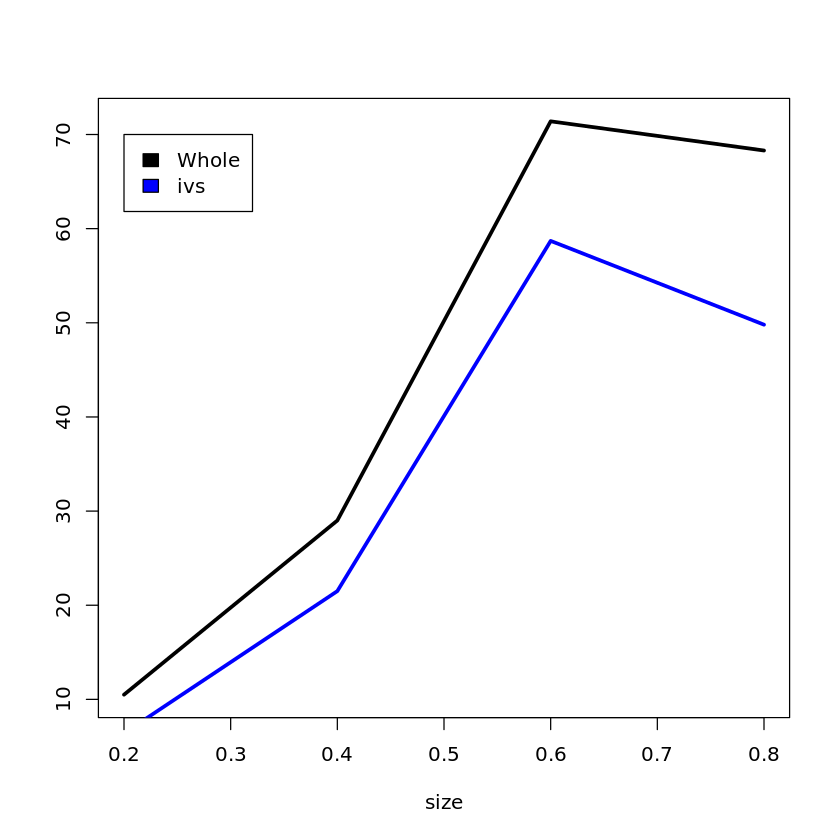

In [4]:
Data_size = c(0.2,0.4,0.6,0.8) # Proportion of the minimal example data
Mem_usage_all=c(10.5,29,71.4,68.3) # data mem usage of the whole program
Mem_usage_ivs=c(6.4,21.5,58.7,49.8) # data mem usage of the function igraph:ivs
plot(size,Mem_usage_all,type="l",lwd=3,col="Black",ylab="")
lines(size,Mem_usage_ivs,type="l",lwd=3,col="Blue")
legend(0.2,70,c("Whole","ivs"),fill=c("black","blue"))

### A little improvement of memory usage

Replace lapply in "keepIDs_multiple <- lapply(relatedPerID, function(x) {" with for loop

For the whloe program, memory usage decreases from 60.3Mb to 56.9Mb while for function "igraph:ivs" memory usage decreases from 30.2Mb to 27.5Mb.

In [1]:
library(profvis)
profvis({
  library(dplyr)
  library(igraph)
  # Remove related individuals while keeping maximum number of individuals
  # this function is simplified from: 
  # https://rdrr.io/cran/plinkQC/src/R/utils.R
  #' @param relatedness [data.frame] containing pair-wise relatedness estimates
  #' (in column [relatednessRelatedness]) for individual 1 (in column
  #' [relatednessIID1] and individual 2 (in column [relatednessIID1]). Columns
  #' relatednessIID1, relatednessIID2 and relatednessRelatedness have to present,
  #' while additional columns such as family IDs can be present. Default column
  #' names correspond to column names in output of plink --genome
  #' (\url{https://www.cog-genomics.org/plink/1.9/ibd}). All original
  #' columns for pair-wise highIBDTh fails will be returned in fail_IBD.
  #' @param relatednessTh [double] Threshold for filtering related individuals.
  #' Individuals, whose pair-wise relatedness estimates are greater than this
  #' threshold are considered related.
  relatednessFilter <- function(relatedness, 
                                relatednessTh,
                                relatednessIID1="IID1", 
                                relatednessIID2="IID2",
                                relatednessRelatedness="KINSHIP") {
    # format data
    if (!(relatednessIID1 %in% names(relatedness))) {
      stop(paste("Column", relatednessIID1, "for relatedness not found!"))
    }
    if (!(relatednessIID2 %in% names(relatedness))) {
      stop(paste("Column", relatednessIID1, "for relatedness not found!"))
    }
    if (!(relatednessRelatedness %in% names(relatedness))) {
      stop(paste("Column", relatednessRelatedness,
                 "for relatedness not found!"))
    }
    
    iid1_index <- which(colnames(relatedness) == relatednessIID1)
    iid2_index <- which(colnames(relatedness) == relatednessIID2)
    
    relatedness[,iid1_index] <- as.character(relatedness[,iid1_index])
    relatedness[,iid2_index] <- as.character(relatedness[,iid2_index])
    
    relatedness_names <- names(relatedness)
    names(relatedness)[iid1_index] <- "IID1"
    names(relatedness)[iid2_index] <- "IID2"
    names(relatedness)[names(relatedness) == relatednessRelatedness] <- "M"
    
    # Remove symmetric IID rows
    relatedness_original <- relatedness
    relatedness <- dplyr::select_(relatedness, ~IID1, ~IID2, ~M)
    
    sortedIDs <- data.frame(t(apply(relatedness, 1, function(pair) {
      c(sort(c(pair[1], pair[2])))
    })), stringsAsFactors=FALSE)
    keepIndex <- which(!duplicated(sortedIDs))
    
    relatedness_original <- relatedness_original[keepIndex,]
    relatedness <- relatedness[keepIndex,]
    
    # individuals with at least one pair-wise comparison > relatednessTh
    # return NULL to failIDs if no one fails the relatedness check
    highRelated <- dplyr::filter_(relatedness, ~M > relatednessTh)
    if (nrow(highRelated) == 0) {
      return(list(relatednessFails=NULL, failIDs=NULL))
    }
    
    # all samples with related individuals
    allRelated <- c(highRelated$IID1, highRelated$IID2)
    uniqueIIDs <- unique(allRelated)
    
    # Further selection of samples with relatives in cohort
    multipleRelative <- unique(allRelated[duplicated(allRelated)])
    singleRelative <- uniqueIIDs[!uniqueIIDs %in% multipleRelative]
    
    highRelatedMultiple <- highRelated[highRelated$IID1 %in% multipleRelative |
                                         highRelated$IID2 %in% multipleRelative,]
    highRelatedSingle <- highRelated[highRelated$IID1 %in% singleRelative &
                                       highRelated$IID2 %in% singleRelative,]
    
    # Only one related samples per individual
    if(length(singleRelative) != 0) {
      # randomly choose one to exclude
      failIDs_single <- highRelatedSingle[,1]
      
    } else {
      failIDs_single <- NULL
    }
    
    # An individual has multiple relatives
    if(length(multipleRelative) != 0) {
      relatedPerID <- lapply(multipleRelative, function(x) {
        tmp <- highRelatedMultiple[rowSums(
          cbind(highRelatedMultiple$IID1 %in% x,
                highRelatedMultiple$IID2 %in% x)) != 0,1:2]
        rel <- unique(unlist(tmp))
        return(rel)
      })
      names(relatedPerID) <- multipleRelative
      
      keepIDs_multiple<-list()
      for (i in 1:length(relatedPerID)){
        x=relatedPerID[[i]]
        pairwise <- t(combn(x, 2))
        index <- (highRelatedMultiple$IID1 %in% pairwise[,1] &
                    highRelatedMultiple$IID2 %in% pairwise[,2]) |
          (highRelatedMultiple$IID1 %in% pairwise[,2] &
             highRelatedMultiple$IID2 %in% pairwise[,1])
        combination <- highRelatedMultiple[index,]
        combination_graph <- igraph::graph_from_data_frame(combination,
                                                           directed=FALSE)
        all_iv_set <- igraph::ivs(combination_graph)
        length_iv_set <- sapply(all_iv_set, function(x) length(x))
        
        if (all(length_iv_set == 1)) {
          # check how often they occurr elsewhere
          occurrence <- sapply(x, function(id) {
            sum(sapply(relatedPerID, function(idlist) id %in% idlist))
          })
          # if occurrence the same everywhere, pick the first, else keep
          # the one with minimum occurrence elsewhere
          if (length(unique(occurrence)) == 1) {
            nonRelated <- sort(x)[1]
          } else {
            nonRelated <- names(occurrence)[which.min(occurrence)]
          }
        } else {
          nonRelated <- all_iv_set[which.max(length_iv_set)]
        }
        keepIDs_multiple[[i]]<-nonRelated
      }
                
      keepIDs_multiple <- unique(unlist(keepIDs_multiple))
      failIDs_multiple <- c(multipleRelative[!multipleRelative %in%
                                               keepIDs_multiple])
    } else {
      failIDs_multiple <- NULL
    }
    allFailIIDs <- c(failIDs_single, failIDs_multiple)
    relatednessFails <- lapply(allFailIIDs, function(id) {
      fail_inorder <- relatedness_original$IID1 == id &
        relatedness_original$M > relatednessTh
      fail_inreverse <- relatedness_original$IID2 == id &
        relatedness_original$M > relatednessTh
      if (any(fail_inreverse)) {
        inreverse <- relatedness_original[fail_inreverse, ]
        id1 <- iid1_index
        id2 <- iid2_index
        inreverse[,c(id1, id2)] <- inreverse[,c(id2, id1)]
        names(inreverse) <- relatedness_names
      } else {
        inreverse <- NULL
      }
      inorder <- relatedness_original[fail_inorder, ]
      names(inorder) <- relatedness_names
      return(rbind(inorder, inreverse))
    })
    relatednessFails <- do.call(rbind, relatednessFails)
    if (nrow(relatednessFails) == 0) {
      relatednessFails <- NULL
      failIDs <- NULL
    } else {
      names(relatednessFails) <- relatedness_names
      rownames(relatednessFails) <- 1:nrow(relatednessFails)
      uniqueFails <- relatednessFails[!duplicated(relatednessFails[,iid1_index]),]
      failIDs <- uniqueFails[,iid1_index]
    }
    return(list(relatednessFails=relatednessFails, failIDs=failIDs))
  }
  
  
  # main code
  kin0 <- read.table('~/bioworkflows/GWAS/data/MWE_fabiha/output/rename_chr22.output.kin0', header=F, stringsAsFactor=F)
  colnames(kin0) <- c("FID1","ID1","FID2","ID2","NSNP","HETHET","IBS0","KINSHIP")
  if (TRUE) {
    rel <- relatednessFilter(kin0, 0.05, "ID1", "ID2", "KINSHIP")$failIDs
    tmp1 <- kin0[,1:2]
    tmp2 <- kin0[,3:4]
    colnames(tmp1) = colnames(tmp2) = c("FID", "ID")
    # Get the family ID for these rels so there are two columns FID and IID in the output
    lookup <- dplyr::distinct(rbind(tmp1,tmp2))
    dat <- lookup[which(lookup[,2] %in% rel),]
  } else {s
    rel <- kin0 %>% filter(KINSHIP >= 0.05)
    IID <- sort(unique(unlist(rel[, c("ID1", "ID2")])))
    dat <- data.frame(IID)
    dat <- dat %>%
      mutate(FID = IID) %>%
      select(FID, IID)
  }
  cat("There are", nrow(dat),"related individuals using a kinship threshold of 0.05\n")
  write.table(dat,'~/bioworkflows/GWAS/data/MWE_fabiha/output/rename_chr22.output.related_id', quote=FALSE, row.names=FALSE, col.names=FALSE)
})


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Warning message:
“`select_()` was deprecated in dplyr 0.7.0.
Please use `select()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message:
“`filter_()` was deprecated in dplyr 0.7.0.
Please use `filter()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


There are 47 related individuals using a kinship threshold of 0.05


HTML widgets cannot be represented in plain text (need html)